# Evaluate model similarity

Here, we evaluate the model similarity of 10 different initializations of our chosen rank.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from pathlib import Path

import numpy as onp
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from dtd.data import load_wiltschko22_data
from dtd.utils import (
    create_block_speckled_mask,
    download_wnb_params,
    get_wnb_project_df
)
from dtd.viz import (
    draw_drug_class_boxes,
    set_syllable_cluster_ticks,
    set_time_within_session_ticks,
)

In [2]:
# Project is specified by <entity/project-name>
wnb_entity = 'eyz'
wnb_project = 'moseq-dtd-fit-20250130'

In [3]:
DATASET_DIR = "/home/groups/swl1/eyz/data/moseq-drugs/"

filepath = DATASET_DIR + "syllable_binned_1min.npz"
_, batch_axes, event_axes, metadata = load_wiltschko22_data(filepath)
print(metadata.keys())

dict_keys(['session', 'frames_per_bin', 'frames_per_sec', 'syllable'])


### Load saved parameters

In [4]:
# Parameter files are saved in <base_dir> / <wnb_project> / <run_id> / params.npz

base_dir = Path('/scratch/users/eyz')  # Directory where parameter files are stored. Otherwise, download from WnB server
project_dir = base_dir / wnb_project

run_ids = []
core_tensors = []
session_factors = []
temporal_factors = []
behavior_factors = []
avg_lps = []  # Final training log prob
for run_path in (project_dir).iterdir():
    with onp.load(run_path/'params.npz') as f:
        run_ids.append(run_path.stem)
        core_tensors.append(f['G'])
        session_factors.append(f['F1'])
        temporal_factors.append(f['F2'])
        behavior_factors.append(f['F3'])
        avg_lps.append(f['avg_train_lps'][-1])

# shape (n_inits,...)
core_tensors = onp.array(core_tensors)
session_factors = onp.array(session_factors)
temporal_factors = onp.array(temporal_factors)
behavior_factors = onp.array(behavior_factors)
avg_lps = onp.array(avg_lps)

n_inits = len(run_ids)
print(f"{core_tensors.shape=}")
print(f"{session_factors.shape=}")
print(f"{temporal_factors.shape=}")
print(f"{behavior_factors.shape=}")
print(f"{avg_lps.shape=}")

core_tensors.shape=(10, 20, 4, 30)
session_factors.shape=(10, 500, 20)
temporal_factors.shape=(10, 20, 4)
behavior_factors.shape=(10, 30, 90)
avg_lps.shape=(10,)


In [8]:
run_ids, avg_lps.argmin()

(['flijq0sz',
  'wmvwp2se',
  'wj155x4a',
  't0nzc0ou',
  'i06i0ckv',
  'jlwvmomm',
  'vgy2d3wg',
  '55906fzi',
  'ztfp7nr4',
  'jtnw6kkp'],
 np.int64(2))

In [5]:
n_sessions, n_session_factors = session_factors.shape[-2:]
n_timebins, n_temporal_factors = temporal_factors.shape[-2:]
n_topics, n_syllables = behavior_factors.shape[-2:]

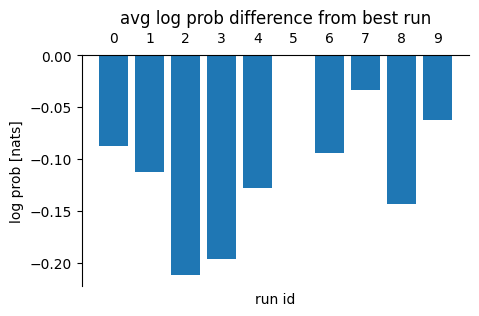

In [6]:
# Compare everything to params wioth best log prob
i_best = avg_lps.argmax()


plt.figure(figsize=(5,3))
ax = plt.gca()

ax.bar(range(n_inits), avg_lps-avg_lps[i_best])
ax.set_xticks(range(n_inits))
ax.set_xlabel('run id', position='top')
ax.set_ylabel('log prob [nats]')
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_title('avg log prob difference from best run')
sns.despine(bottom=True, top=False)

## Compare factors from different fits

In [7]:
refr_init = 5
discrete_total_variation = lambda u, v: 0.5 * onp.sum(onp.abs(u-v))

### Behavior factors aka topics

In [57]:
permutations = []
permuted_dists = []
for i_init in range(n_inits):
    if i_init == refr_init:
        j_permute = onp.arange(n_topics)
        d = onp.zeros(n_topics)
    else:
        cost_mat = cdist(behavior_factors[refr_init], behavior_factors[i_init], metric=discrete_total_variation)
        _, j_permute = linear_sum_assignment(cost_mat)
        d = onp.diag(cost_mat[:,j_permute])

    permutations.append(j_permute)
    permuted_dists.append(d)

permutations = onp.array(permutations)
permuted_dists = onp.array(permuted_dists)

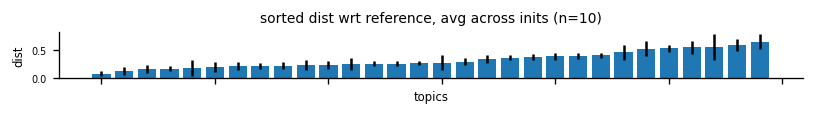

In [58]:
# Calculate mean and standard error distance per topic, across initiatializations
mask = onp.ones(n_inits, dtype=bool)
mask[refr_init] = False

mean_dist = onp.mean(permuted_dists[mask], axis=0)
ste_dist = onp.std(permuted_dists[mask], axis=0) / (n_inits-1)**0.5

# sort topics by average distance (from refr)
global_permute = onp.argsort(mean_dist)
mean_dist = mean_dist[global_permute]
ste_dist = ste_dist[global_permute]

fig, ax = plt.subplots(figsize=(8,0.5), dpi=120)
ax.bar(range(n_topics), mean_dist, yerr=1.96*ste_dist)
ax.set_xlabel("topics", fontsize='x-small', labelpad=0)
ax.set_ylabel('dist', fontsize='x-small')
ax.set_xticklabels([])
ax.tick_params(labelsize='xx-small')

ax.set_title(f"sorted dist wrt reference, avg across inits (n={n_inits})", fontsize='small')
sns.despine()

In [59]:
# Compound the permutations:
# First, permute topics to best match reference
# Next, permute topics by greatest to least similarity
permuted_behavior_factors = onp.array([
    (factor[permute])[global_permute] for factor, permute in zip(behavior_factors, permutations)
])

**View by init**

vmax=np.float32(0.26546654)


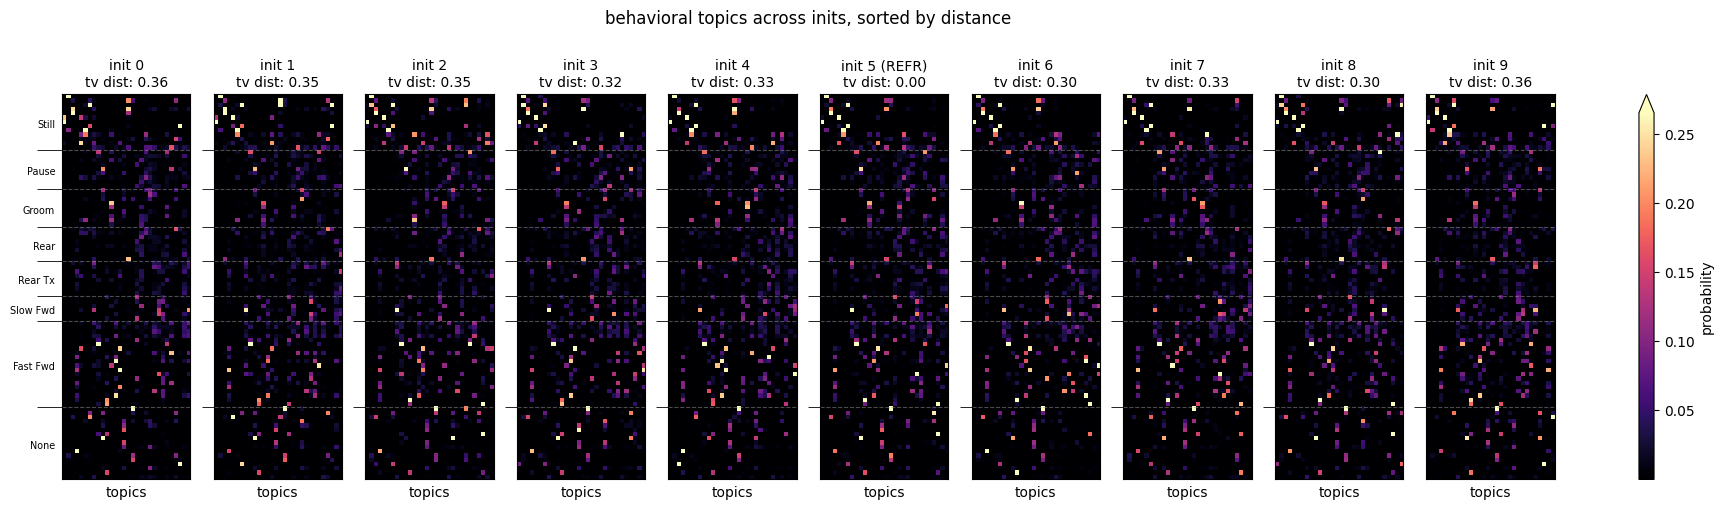

In [17]:
vmax = onp.percentile(behavior_factors, 99.5)
imshow_kwargs = dict(vmax=vmax, cmap='magma', interpolation='none')
print(f"{vmax=}")

fig = plt.figure(figsize=(16,5))
fig.subplots_adjust(left=0,right=1)
main_subfig, cbar_subfig = fig.subfigures(ncols=2, width_ratios=[10,0.1], wspace=0.1)
axs = main_subfig.subplots(ncols=n_inits, gridspec_kw=dict(wspace=0.05))

for i_init in range(n_inits):
    ax = axs[i_init]

    # Compound the permutations:
    # First, permute topics to best match reference
    # Next, permute topics by greatest to least similarity
    # j_permute = (permutations[i_init])[topics_permute]
    # im = ax.imshow(behavior_factors[i_init][j_permute].T, **imshow_kwargs)
    im = ax.imshow(permuted_behavior_factors[i_init].T, **imshow_kwargs)

    title = f"init {i_init}"
    title += " (REFR)" if i_init == refr_init else ""
    title += f"\ntv dist: {permuted_dists[i_init].mean():.2f}"
    ax.set_title(title, fontsize='medium')

    ax.set_xticks([])
    ax.set_xlabel('topics')
    set_syllable_cluster_ticks(
        metadata['syllable']['cluster_names'],
        label=(i_init == 0), axis='y', ax=ax
    )

main_subfig.suptitle('behavioral topics across inits, sorted by distance', y=1.05)

cax = cbar_subfig.subplots()
plt.colorbar(im, cax=cax, extend='max', label='probability')

**View by topic**

<>:54: SyntaxWarning: invalid escape sequence '\p'
<>:54: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_208346/2344976222.py:54: SyntaxWarning: invalid escape sequence '\p'
  main_subfig.suptitle(f'topics vs. inits, sorted by distance wrt refr (mean $\pm$ 95% CI)', y=1.1)


vmax=np.float32(0.26546654)


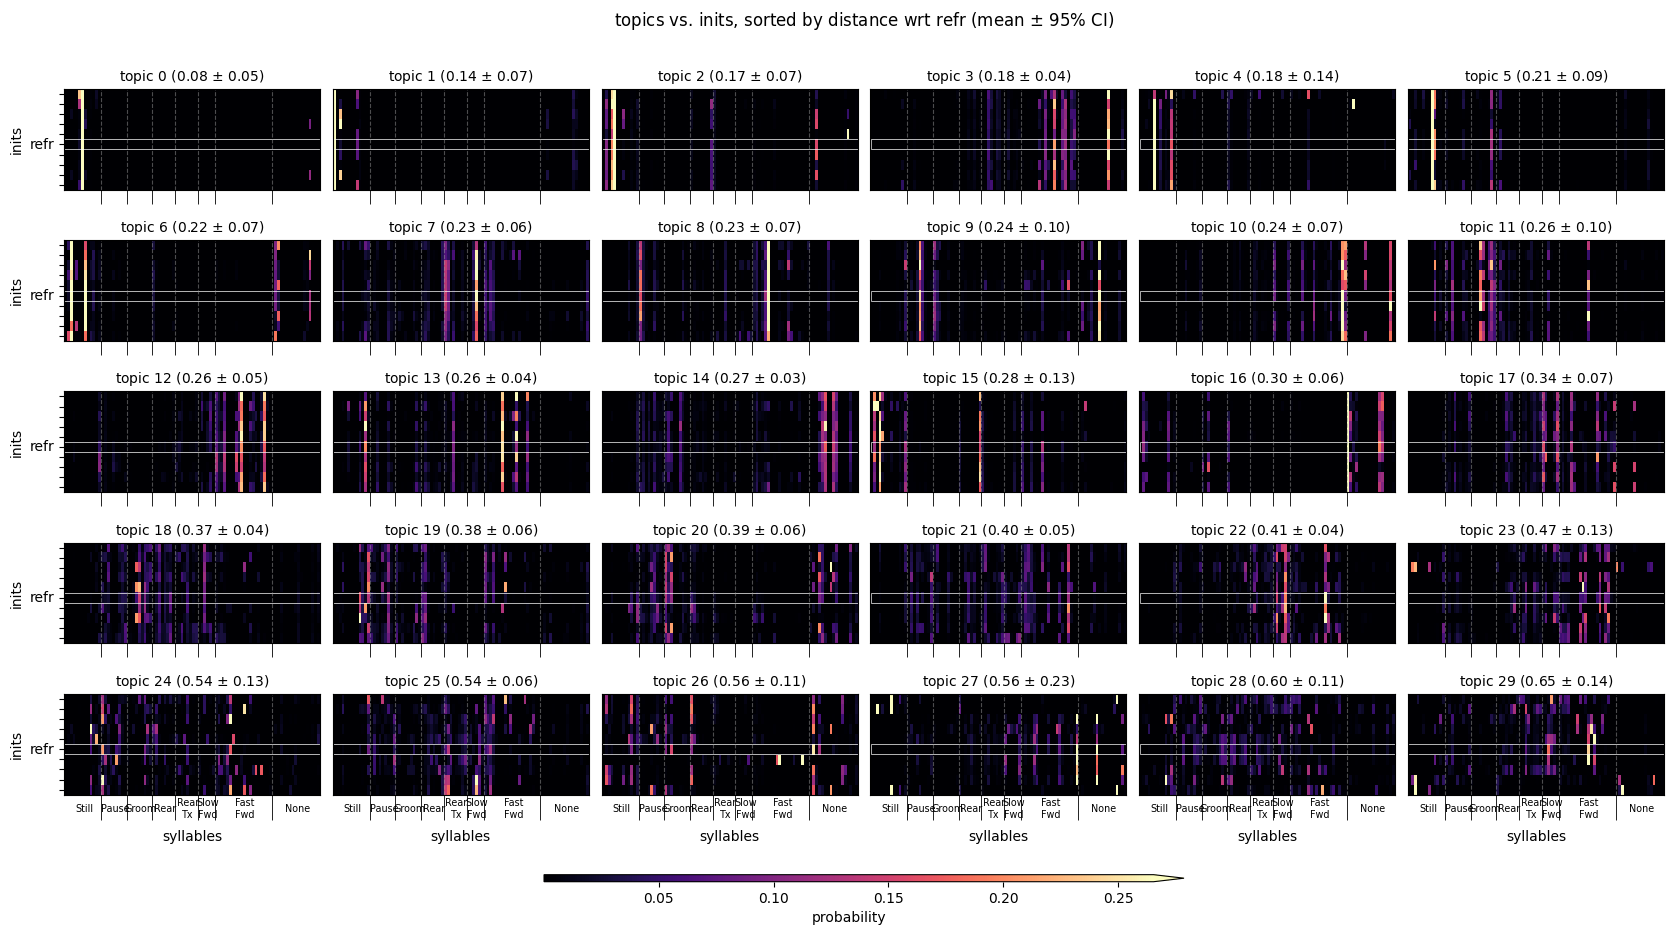

In [75]:
vmax = onp.percentile(behavior_factors, 99.5)
imshow_kwargs = dict(vmax=vmax, cmap='magma', interpolation='none', aspect='auto')
print(f"{vmax=}")

fig = plt.figure(figsize=(16,8))
fig.subplots_adjust(left=0,right=1)
main_subfig, cbar_subfig = fig.subfigures(nrows=2, height_ratios=[10,0.1], hspace=0.2)

ncols = 6
nrows = n_topics // ncols
main_subfig.subplots_adjust(top=0.99, bottom=0.01)
axs = main_subfig.subplots(
    nrows=nrows, ncols=ncols, gridspec_kw=dict(wspace=0.05, hspace=0.5)
)

for i_topic, ax in enumerate(axs.ravel()):
    im = ax.imshow(permuted_behavior_factors[:,i_topic,:], **imshow_kwargs)

    title = rf"topic {i_topic} ({mean_dist[i_topic]:.2f} $\pm$ {1.96*ste_dist[i_topic]:.2f})"
    ax.set_title(title, fontsize='medium')
    
    set_syllable_cluster_ticks(
        metadata['syllable']['cluster_names'],
        label=False, axis='x', ax=ax
    )
    ax.tick_params(axis='x', which='minor', length=10)

    # Point out reference init
    ax.set_yticks([])

    # Draw rectangle around reference row
    rect = mpl.patches.Rectangle(
        (-0.4, refr_init-0.5), n_syllables+0.5, 1,  # (x,y), width, height
        fc='none', ec='white', lw=0.5,
    )
    ax.add_patch(rect)

# First column
ytick_labels = ['',] * n_inits
ytick_labels[refr_init] = 'refr'
for ax in axs[:,0]:
    ax.set_ylabel('inits')
    ax.set_yticks(range(n_inits))
    ax.set_yticklabels(ytick_labels, va='center')

# Bottom row
for ax in axs[-1]:
    set_syllable_cluster_ticks(
        metadata['syllable']['cluster_names'], label=True, axis='x', ax=ax
    )
    # ax.tick_params(axis='x', labelbottom=True)
    ax.set_xlabel('syllables')

main_subfig.suptitle(f'topics vs. inits, sorted by distance wrt refr (mean $\pm$ 95% CI)', y=1.1)

# Colorbar
cbar_subfig.subplots_adjust(left=0.3, right=0.7)
cax = cbar_subfig.subplots()
plt.colorbar(im, cax=cax, orientation='horizontal', extend='max', label='probability');

First 15

<>:56: SyntaxWarning: invalid escape sequence '\p'
<>:56: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_231347/3973184776.py:56: SyntaxWarning: invalid escape sequence '\p'
  main_subfig.suptitle(f'topics vs. inits, sorted by distance wrt refr (mean $\pm$ 95% CI)', y=1.1)


vmax=np.float32(0.26546654)


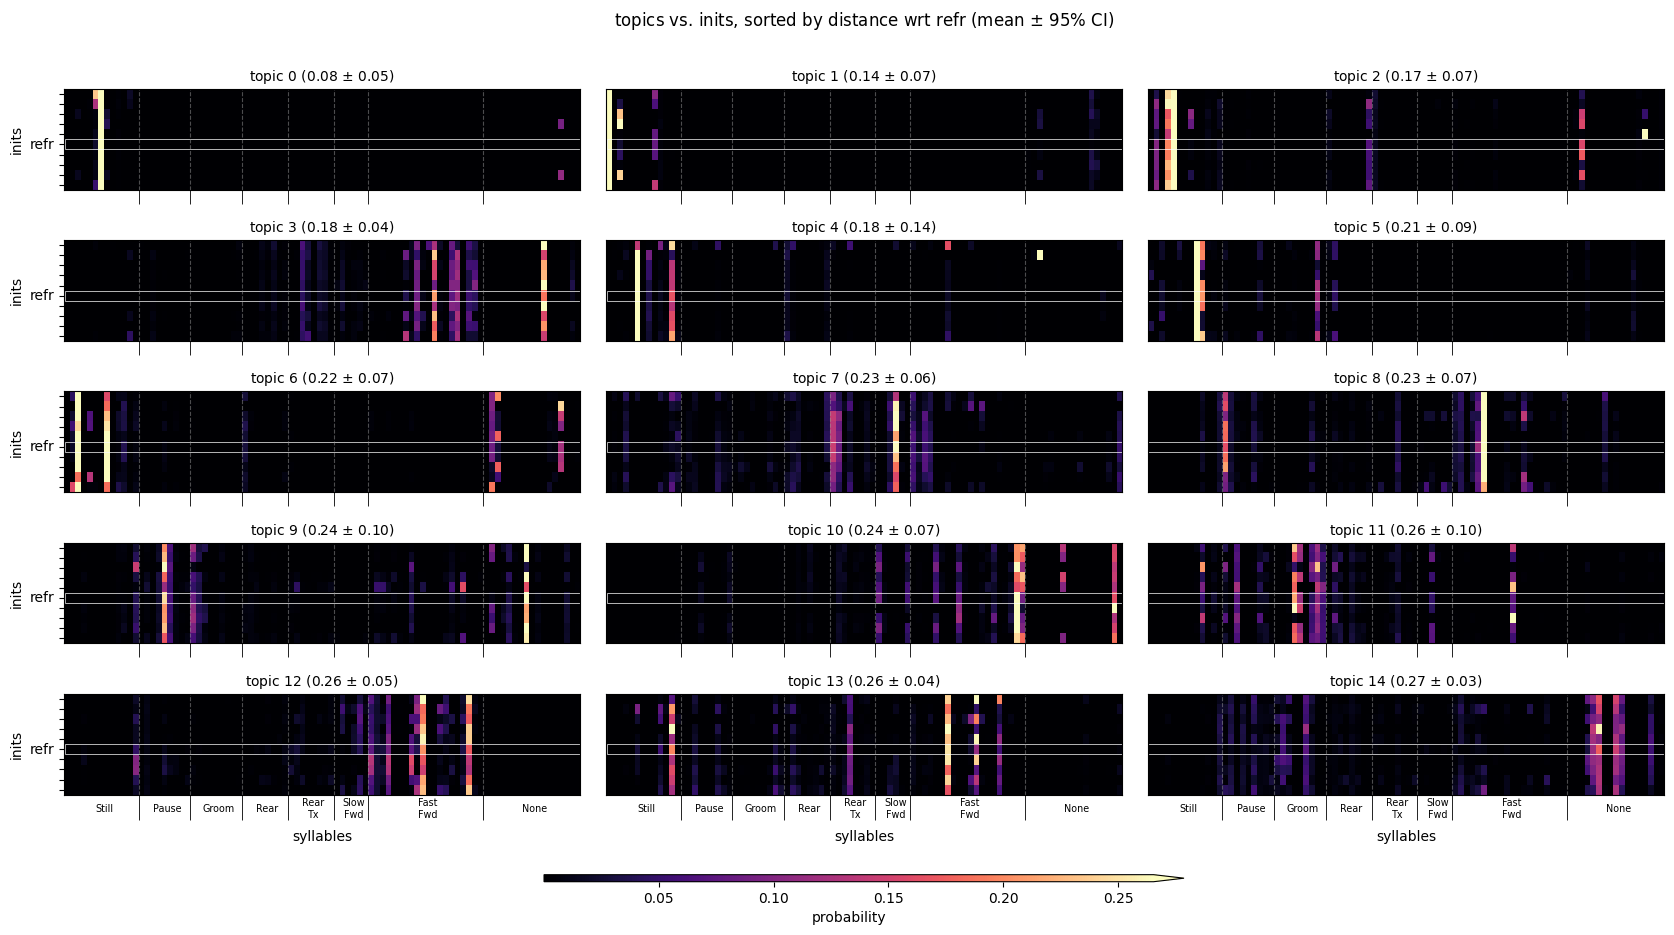

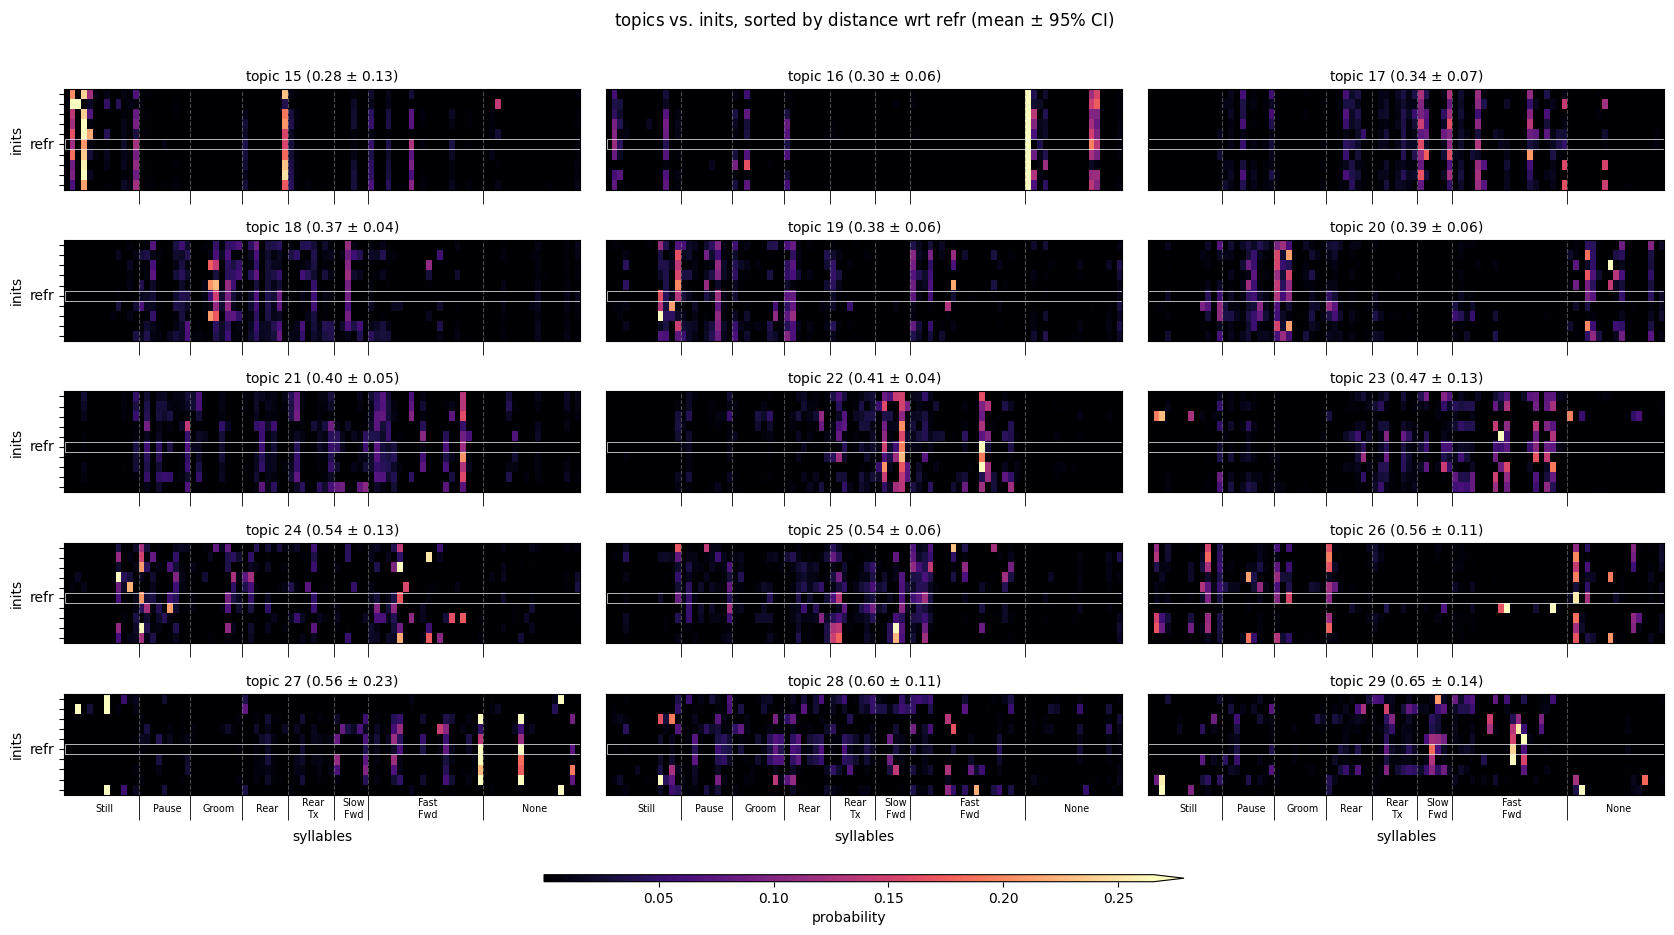

In [62]:
vmax = onp.percentile(behavior_factors, 99.5)
imshow_kwargs = dict(vmax=vmax, cmap='magma', interpolation='none', aspect='auto')
print(f"{vmax=}")

for i_offset in [0,15]:
    fig = plt.figure(figsize=(16,8))
    fig.subplots_adjust(left=0,right=1)
    main_subfig, cbar_subfig = fig.subfigures(nrows=2, height_ratios=[10,0.1], hspace=0.2)

    ncols = 3
    nrows = 15 // ncols
    main_subfig.subplots_adjust(top=0.99, bottom=0.01)
    axs = main_subfig.subplots(
        nrows=nrows, ncols=ncols, gridspec_kw=dict(wspace=0.05, hspace=0.5)
    )

    for i_ax, ax in enumerate(axs.ravel()):
        i_topic = i_ax + i_offset
        im = ax.imshow(permuted_behavior_factors[:,i_topic,:], **imshow_kwargs)

        title = rf"topic {i_topic} ({mean_dist[i_topic]:.2f} $\pm$ {1.96*ste_dist[i_topic]:.2f})"
        ax.set_title(title, fontsize='medium')
        
        set_syllable_cluster_ticks(
            metadata['syllable']['cluster_names'],
            label=False, axis='x', ax=ax
        )
        ax.tick_params(axis='x', which='minor', length=10)

        # Point out reference init
        ax.set_yticks([])

        # Draw rectangle around reference row
        rect = mpl.patches.Rectangle(
            (-0.4, refr_init-0.5), n_syllables+0.5, 1,  # (x,y), width, height
            fc='none', ec='white', lw=0.5,
        )
        ax.add_patch(rect)

    # First column
    ytick_labels = ['',] * n_inits
    ytick_labels[refr_init] = 'refr'
    for ax in axs[:,0]:
        ax.set_ylabel('inits')
        ax.set_yticks(range(n_inits))
        ax.set_yticklabels(ytick_labels, va='center')

    # Bottom row
    for ax in axs[-1]:
        set_syllable_cluster_ticks(
            metadata['syllable']['cluster_names'], label=True, axis='x', ax=ax
        )
        # ax.tick_params(axis='x', labelbottom=True)
        ax.set_xlabel('syllables')

    main_subfig.suptitle(f'topics vs. inits, sorted by distance wrt refr (mean $\pm$ 95% CI)', y=1.1)

    # Colorbar
    cbar_subfig.subplots_adjust(left=0.3, right=0.7)
    cax = cbar_subfig.subplots()
    plt.colorbar(im, cax=cax, orientation='horizontal', extend='max', label='probability');

    plt.show()

### Temporal factors

In [63]:
permutations = []
permuted_dists = []
for i_init in range(n_inits):
    if i_init == refr_init:
        j_permute = onp.arange(n_temporal_factors)
        d = onp.zeros(n_temporal_factors)
    else:
        cost_mat = cdist(temporal_factors[refr_init].T, temporal_factors[i_init].T, metric=discrete_total_variation)
        _, j_permute = linear_sum_assignment(cost_mat)
        d = onp.diag(cost_mat[:,j_permute])

    permutations.append(j_permute)
    permuted_dists.append(d)

permutations = onp.array(permutations)
permuted_dists = onp.array(permuted_dists)

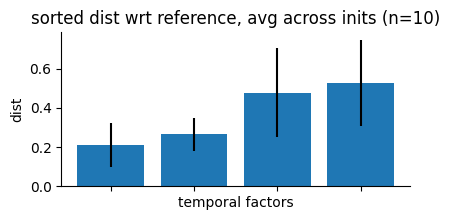

In [64]:
# Calculate mean and standard error distance per topic, across initiatializations
mask = onp.ones(n_inits, dtype=bool)
mask[refr_init] = False

mean_dist = onp.mean(permuted_dists[mask], axis=0)
ste_dist = onp.std(permuted_dists[mask], axis=0) / (n_inits-1)**0.5

# sort topics by average distance (from refr)
global_permute = onp.argsort(mean_dist)
mean_dist = mean_dist[global_permute]
ste_dist = ste_dist[global_permute]
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(4.5,2))
ax.bar(range(len(mean_dist)), mean_dist, yerr=1.96*ste_dist)
ax.set_xlabel("temporal factors", labelpad=0)
ax.set_ylabel('dist')
ax.set_xticklabels([])
ax.tick_params()

ax.set_title(f"sorted dist wrt reference, avg across inits (n={n_inits})")
sns.despine()

In [10]:
# Compound the permutations:
# First, permute topics to best match reference
# Next, permute topics by greatest to least similarity
permuted_temporal_factors = onp.array([
    (factor[:,permute])[:,global_permute] for factor, permute in zip(temporal_factors, permutations)
])

**View by init**

vmax=1


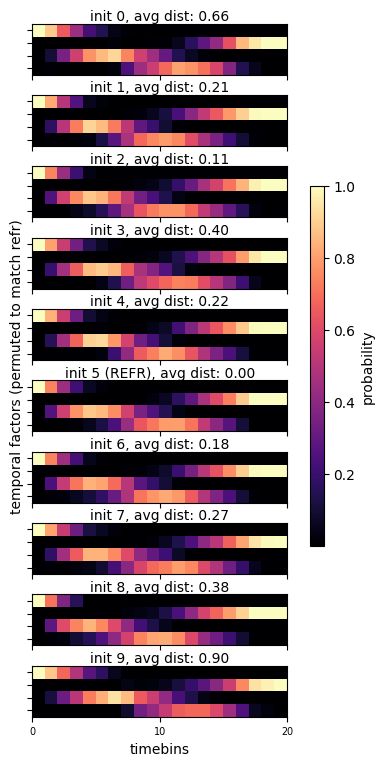

In [65]:
vmax = 1
imshow_kwargs = dict(vmax=vmax, cmap='magma', interpolation='none')
print(f"{vmax=}")

fig = plt.figure(figsize=(3,9))
fig.subplots_adjust(left=0, right=1)
main_subfig, cbar_subfig = fig.subfigures(ncols=2, width_ratios=[1,0.05], wspace=0.1)

axs = main_subfig.subplots(nrows=n_inits, gridspec_kw=dict(hspace=0.4))

for i_init in range(n_inits):
    ax = axs[i_init]

    im = ax.imshow(permuted_temporal_factors[i_init].T, **imshow_kwargs)

    title = f"init {i_init}"
    title += " (REFR), " if i_init == refr_init else ", "
    title += f"avg dist: {permuted_dists[i_init].mean():.2f}"
    ax.set_title(title, fontsize='medium', y=0.9)

    set_time_within_session_ticks(
        n_timebins, metadata['frames_per_bin'], metadata['frames_per_sec'],
        tick_period=10, label=(i_init == n_inits-1), ax=ax
    )

    ax.set_yticks(range(n_temporal_factors))
    ax.set_yticklabels([])

axs[-1].set_xlabel('timebins')
# add global y label
main_subfig.text(
    -0.05, 0.5, 'temporal factors (permuted to match refr)', transform=main_subfig.transSubfigure,
    rotation=90, ha='left', va='center',
)
# main_subfig.suptitle('behavioral topics across inits, sorted by distance', y=1.05)

cbar_subfig.subplots_adjust(top=0.7, bottom=0.3)
cax = cbar_subfig.subplots()
plt.colorbar(im, cax=cax, extend='max' if vmax < 1 else 'neither', label='probability')

**View by factor**

<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_231347/2220405865.py:16: SyntaxWarning: invalid escape sequence '\p'
  title = f"factor {i_factor} ({mean_dist[i_factor]:.2f} $\pm$ {1.96*ste_dist[i_factor]:.2f})"


vmax=1


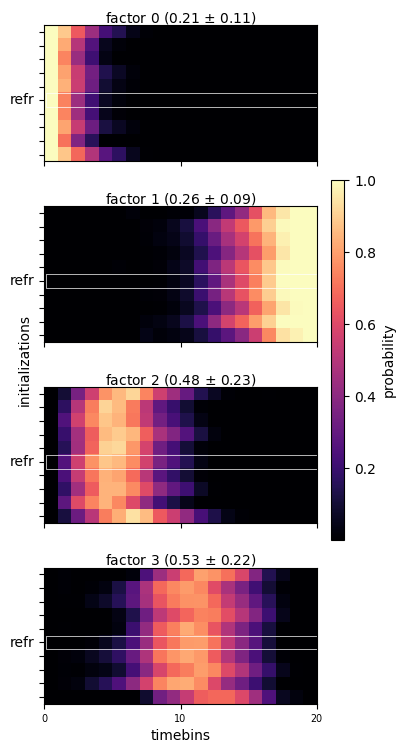

In [43]:
vmax = 1
imshow_kwargs = dict(vmax=vmax, cmap='magma', interpolation='none')
print(f"{vmax=}")

fig = plt.figure(figsize=(3,9))
fig.subplots_adjust(left=0, right=1)
main_subfig, cbar_subfig = fig.subfigures(ncols=2, width_ratios=[1,0.05], wspace=0.1)

axs = main_subfig.subplots(nrows=n_temporal_factors, gridspec_kw=dict(hspace=0.2))

for i_factor in range(n_temporal_factors):
    ax = axs[i_factor]

    im = ax.imshow(permuted_temporal_factors[:,:,i_factor], **imshow_kwargs)

    title = f"factor {i_factor} ({mean_dist[i_factor]:.2f} $\pm$ {1.96*ste_dist[i_factor]:.2f})"
    ax.set_title(title, fontsize='medium', y=0.96)

    set_time_within_session_ticks(
        n_timebins, metadata['frames_per_bin'], metadata['frames_per_sec'],
        tick_period=10, label=(i_factor == n_temporal_factors-1), ax=ax
    )

    ax.set_yticks(range(n_inits))
    ax.set_yticklabels([])
    
    # Draw rectangle around reference row
    rect = mpl.patches.Rectangle(
        (-0.4, refr_init-0.5), n_syllables+0.5, 1,  # (x,y), width, height
        fc='none', ec='white', lw=0.5,
    )
    ax.add_patch(rect)

axs[-1].set_xlabel('timebins')

ytick_labels = ['',] * n_inits
ytick_labels[refr_init] = 'refr'
for ax in axs:
    ax.set_yticks(range(n_inits))
    ax.set_yticklabels(ytick_labels, va='center')

# add global y label
main_subfig.text(
    -0.1, 0.5, 'initializations', transform=main_subfig.transSubfigure,
    rotation=90, ha='left', va='center',
)
# main_subfig.suptitle('behavioral topics across inits, sorted by distance', y=1.05)

cbar_subfig.subplots_adjust(top=0.7, bottom=0.3)
cax = cbar_subfig.subplots()
plt.colorbar(im, cax=cax, extend='max' if vmax < 1 else 'neither', label='probability');

### Session factors

In [69]:
permutations = []
permuted_dists = []
for i_init in range(n_inits):
    if i_init == refr_init:
        j_permute = onp.arange(n_session_factors)
        d = onp.zeros(n_session_factors)
    else:
        cost_mat = cdist(session_factors[refr_init].T, session_factors[i_init].T, metric=discrete_total_variation)
        _, j_permute = linear_sum_assignment(cost_mat)
        d = onp.diag(cost_mat[:,j_permute])

    permutations.append(j_permute)
    permuted_dists.append(d)

permutations = onp.array(permutations)
permuted_dists = onp.array(permuted_dists)

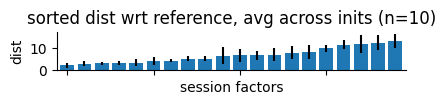

In [104]:
# Calculate mean and standard error distance per topic, across initiatializations
mask = onp.ones(n_inits, dtype=bool)
mask[refr_init] = False

mean_dist = onp.mean(permuted_dists[mask], axis=0)
ste_dist = onp.std(permuted_dists[mask], axis=0) / (n_inits-1)**0.5

# sort topics by average distance (from refr)
global_permute = onp.argsort(mean_dist)
mean_dist = mean_dist[global_permute]
ste_dist = ste_dist[global_permute]
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(4.5,0.5))
ax.bar(range(len(mean_dist)), mean_dist, yerr=1.96*ste_dist)
ax.set_xlabel("session factors", labelpad=0)
ax.set_ylabel('dist')
ax.set_xticklabels([])
ax.tick_params()
ax.margins(x=0.01)
ax.set_title(f"sorted dist wrt reference, avg across inits (n={n_inits})")
sns.despine()

In [71]:
permuted_session_factors = onp.array([
    (factor[:,permute])[:,global_permute] for factor, permute in zip(session_factors, permutations)
])
permuted_session_factors.shape

(10, 500, 20)

**View by factor**

<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_231347/1041986896.py:17: SyntaxWarning: invalid escape sequence '\p'
  title = f"factor {i_factor}\n({mean_dist[i_factor]:.2f} $\pm$ {1.96*ste_dist[i_factor]:.2f})"


vmax=1


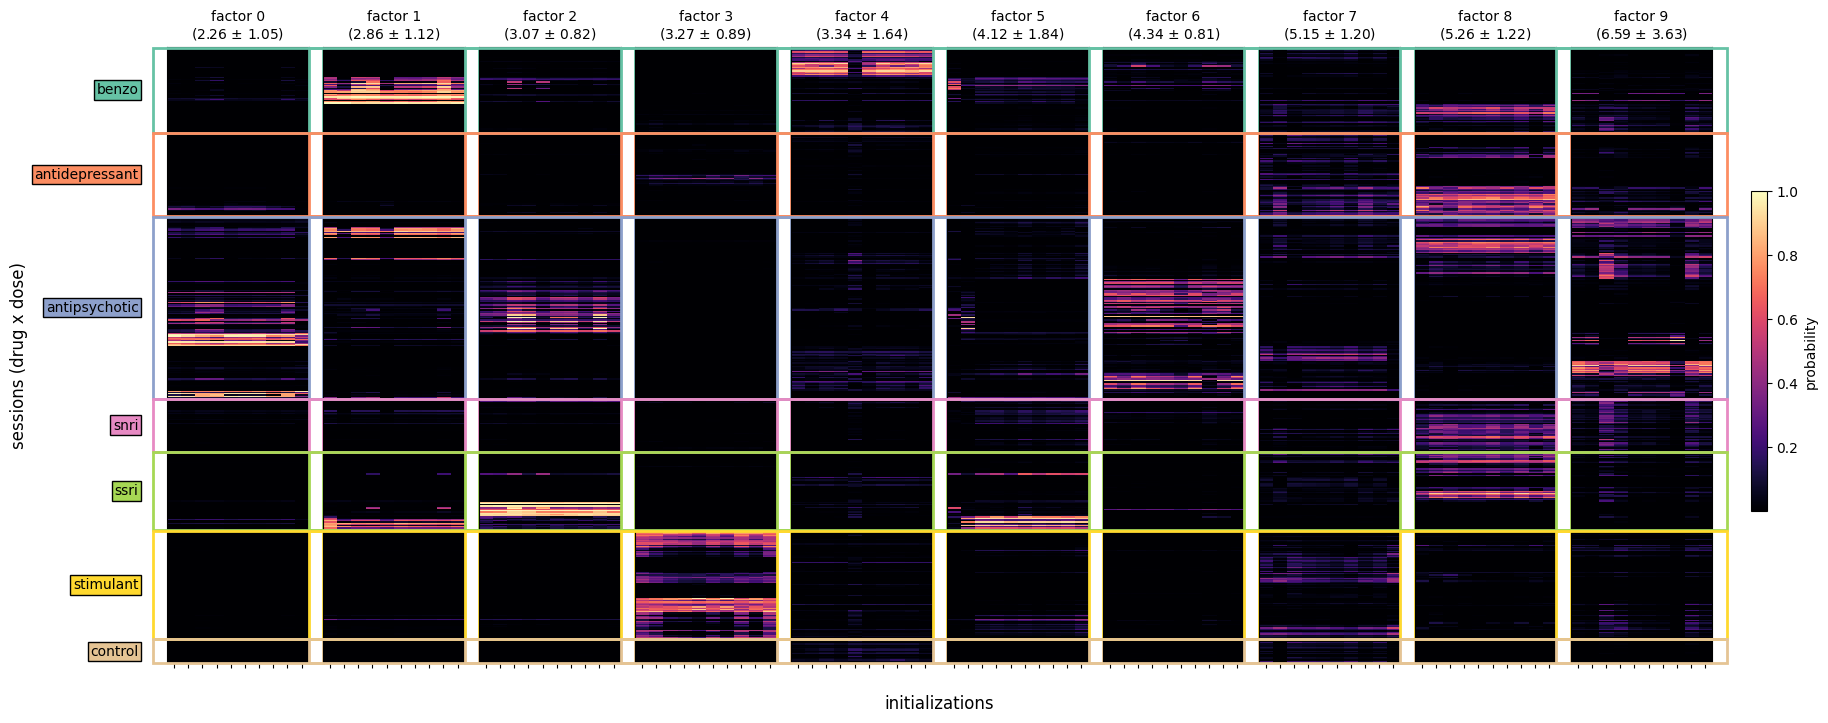

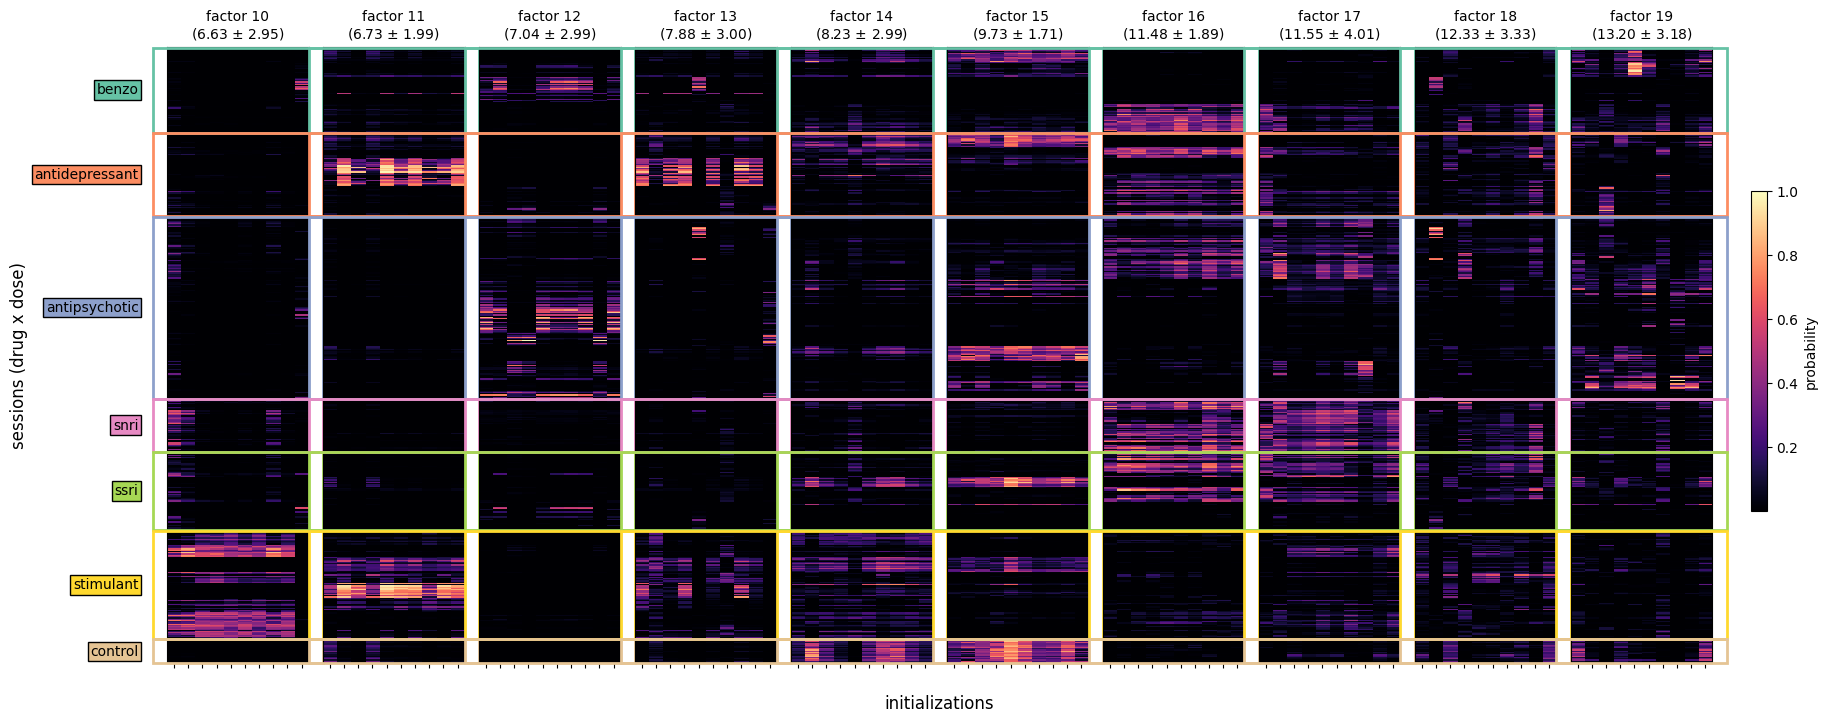

In [106]:
vmax = 1
imshow_kwargs = dict(vmax=vmax, cmap='magma', interpolation='none', aspect='auto')
print(f"{vmax=}")

for offset in [0,10]:
    fig = plt.figure(figsize=(16,8))
    fig.subplots_adjust(left=0, right=1)
    main_subfig, cbar_subfig = fig.subfigures(ncols=2, width_ratios=[10,0.1], wspace=0.05)

    axs = main_subfig.subplots(ncols=10, gridspec_kw=dict(wspace=0.1))

    for i_ax, ax in enumerate(axs.ravel()):
        i_factor = i_ax + offset

        im = ax.imshow(permuted_session_factors[:,:,i_factor].T, **imshow_kwargs)

        title = f"factor {i_factor}\n({mean_dist[i_factor]:.2f} $\pm$ {1.96*ste_dist[i_factor]:.2f})"
        ax.set_title(title, fontsize='medium', y=1)

        ax.set_xticks(range(n_inits))
        ax.set_xticklabels([])

        ax.set_yticks([])
        draw_drug_class_boxes(
            metadata['session']['drug_class'], label=(i_ax==0), ax=ax
        )

    axs[0].set_ylabel('sessions (drug x dose)', labelpad=100, fontsize='large')

    # add global x label
    main_subfig.text(
        0.5, 0.07, 'initializations', transform=main_subfig.transSubfigure,
        ha='center', va='top', fontsize='large'
    )
    # main_subfig.suptitle('behavioral topics across inits, sorted by distance', y=1.05)

    cbar_subfig.subplots_adjust(top=0.7, bottom=0.3)
    cax = cbar_subfig.subplots()
    plt.colorbar(im, cax=cax, extend='max' if vmax < 1 else 'neither', label='probability');

    plt.show()